## Find gamma rates of K-40 and Tl-208 in lab data (vz1)

#### Din-Ammar Tolj - Y25
Maruyama Group, Summer 2023

This notebook fits Gaussians to K-40 and Tl-208 compton edges from lab data in order to find the gamma fluxes of these isotopes. This data is used to compare to the LNGS data from the paper Samantha sent.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import moyal, chisquare

import ROOT
from root_numpy import array2hist, hist2array, fill_hist
from array import array

import sys
import math

import matplotlib as mpl
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import seaborn as sns
%matplotlib inline
# import deDisperse_util as util
import matplotlib.colors as colors

mpl.rcParams['text.usetex'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

current_palette = sns.color_palette('colorblind', 10)
mpl.style.use('seaborn-colorblind')

from scipy.optimize import curve_fit
import scipy.signal
from lmfit.models import GaussianModel, ConstantModel
from datetime import datetime
from glob import glob

%cd libs/
from dt5202 import dt5202_crunch # Import parser that Tom wrote. This is containted in the file named dt5202.py in this folder.
from dt5202oldDAQ import dt5202_crunch as dt5202_crunch_oldDAQ # Old ver
ped = 50 #pedestal correction

from langaus import LanGausFit # Import Langaus fit curve for PyROOT.
%cd -

import warnings
warnings.filterwarnings("ignore")

/vast/palmer/home.grace/dt592/Geant4Work/libs
/vast/palmer/home.grace/dt592/Geant4Work


/tmp/ipykernel_30754/3102545090.py:27: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command


### Load and read lab data from directory

In [2]:
sourceFolder = "/home/dt592/data/board1771_01192023_retestingSwirlyPanel/"

onlyfiles = [f for f in os.listdir(sourceFolder) if '.dat' in f]

data_list = []
for file in onlyfiles:
    data_list.append(dt5202_crunch(str(sourceFolder)+str(file), num_ev=100000000, num_ch=1))

data = data_list[0]
for i in range(1, len(data_list)):
    data = np.append(data, data_list[i])

[(259, [3, 0, 3], 1, 0, 288, 0.5, 1674156932637)]
((33, 0, 1.67415693e+09, 0, 1), (0, 3, 7938, 8051))
[(259, [3, 0, 3], 1, 0, 288, 0.5, 1674157533007)]
((33, 0, 1.67415753e+09, 0, 1), (0, 3, 1110, 8051))


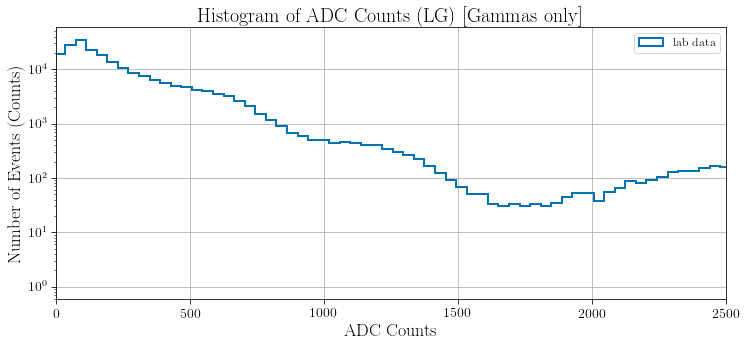

In [3]:
plt.figure(figsize=(12,5))

plt.hist(data['data']['low_gain']-ped, bins=200, lw = 2, label='lab data', histtype='step')

plt.xlim(0,2500)
plt.xlabel('ADC Counts')
plt.ylabel('Number of Events (Counts)')
plt.title('Histogram of ADC Counts (LG) [Gammas only]')
plt.legend()
plt.yscale('log')
plt.grid()
plt.show()

In [4]:
# Turn data into a ROOT Histogram
c1 = ROOT.TCanvas('c1','', 200, 10, 750, 450)
hpx = ROOT.TH1D('Gaussian Fit', 'Lab Data, LG', 200, 0, 2500)
fill_hist(hpx, data['data']['low_gain']-ped)

 FCN=86.0061 FROM MIGRAD    STATUS=CONVERGED     110 CALLS         111 TOTAL
                     EDM=1.36782e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.50800e+03   2.72889e+01   4.06992e-02   6.99823e-05
   2  Mean         4.39543e+02   1.17581e+01   7.27481e-03  -1.72489e-04
   3  Sigma        2.18073e+02   7.20658e+00   1.56288e-05  -1.86776e-01
 FCN=67.9277 FROM MIGRAD    STATUS=CONVERGED      95 CALLS          96 TOTAL
                     EDM=8.06991e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.44595e+02   3.61889e+00   9.27223e-03   1.12840e-04
   2  Mean         1.05785e+03   1.69003e+01   1.76542e-02   4.02824e-05
   3  Sigma        2.34936e+02   

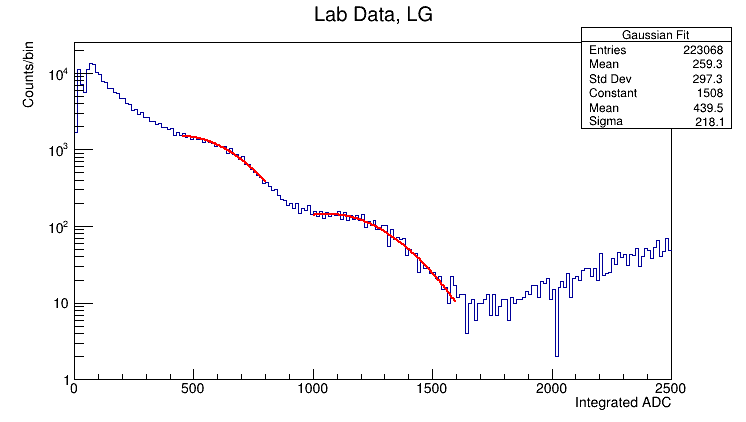

In [12]:
par = array( 'd', 9*[0.] )
g1 = ROOT.TF1( 'g1', 'gaus',  450,  800 )
g2 = ROOT.TF1( 'g2', 'gaus',  1000,  1600 )

hpx.Draw()
ROOT.gPad.SetLogy()
ROOT.gStyle.SetOptFit(2)

hpx.GetXaxis().SetTitle("Integrated ADC")
hpx.GetYaxis().SetTitle("Counts/bin")

hpx.Fit( g1, 'R' )
hpx.Fit( g2, 'R+' )

par1 = g1.GetParameters()
par2 = g2.GetParameters()

c1.Draw()

In [13]:
binWidth = hpx.GetBinWidth(1)
g1Flux = g1.Integral(450,  800)/(10*0.000694444*25*0.01*0.01*25*binWidth)
g1Flux = "{:e}".format(g1Flux)
g2Flux = g2.Integral(1000,  1600)/(10*0.000694444*25*0.01*0.01*25*binWidth)
g2Flux = "{:e}".format(g2Flux)
print("The K-40 flux is: ", g1Flux, "gammas/m^2/day")
print("The Tl-208 flux is: ", g2Flux, "gammas/m^2/day")

The K-40 flux is:  6.559193e+07 gammas/m^2/day
The Tl-208 flux is:  9.208984e+06 gammas/m^2/day
